In [1]:
#importing all necessary libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

from base64 import b64encode
from IPython.display import HTML

import caiman as cm
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf.online_cnmf import OnACID
from caiman.utils.visualization import inspect_correlation_pnr

from tqdm import tqdm
# from statsmodels.stats.multitest import multipletests
from scipy import stats as st
from caiman.source_extraction.cnmf import params as params
import cv2 as cv
from pathlib import Path

import networkx as nx

2022-12-08 21:53:38.300559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

orig = '/central/groups/RaraeAves/nathaniel/miniscope_data/sample_data_fr_jiang/chunk0/ds/chunk0_ds.avi'
cap = cv.VideoCapture(orig)
fn = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
ht = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
wd = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
fname_new =(Path(orig).parent/f"{Path(orig).stem}_d1_{ht}_d2_{wd}_d3_1_order_F_frames_{fn}_.mmap").as_posix()
cnmf_path = (Path(orig).parent/'cnmf.hdf5').as_posix()
cnm = cnmf.load_CNMF(cnmf_path, dview = dview)

opts_dict = np.load(Path(orig).parent/"opts.npy", allow_pickle = True).item()
opts_dict = {j: k for i in opts_dict.values() for j, k in i.items()}
opts = params.CNMFParams(params_dict = opts_dict)

In [3]:
nframes_corr = 45000
nskip = 5
if (not (Path(orig).parent/f'local_corr_{nframes_corr}_skip_{nskip}.npy').exists()) or (not (Path(orig).parent/f'pnr_{nframes_corr}_skip_{nskip}.npy').exists()):
    Yr, dims, T = cm.load_memmap(fname_new)
    images = np.reshape(Yr.T, [T] + list(dims), order='F')
    cn, pnr = cm.summary_images.correlation_pnr(images[:nframes_corr:nskip], gSig= opts.get('init', 'gSig')[0] * opts.get('online', 'ds_factor'), swap_dim=False) 
    np.save(Path(orig).parent/f'local_corr_{nframes_corr}.npy', cn)
    np.save(Path(orig).parent/f'pnr_{nframes_corr}.npy', pnr)
else:
    cn = np.load(Path(orig).parent/f'local_corr_{nframes_corr}_skip_{nskip}.npy')
    pnr = np.load(Path(orig).parent/f'pnr_{nframes_corr}_skip_{nskip}.npy')
cn2 = cn.copy()
cn2[cn2<.85]=.85
cnm.estimates.plot_contours(img =  cn , display_numbers = False, thr = .6, thr_method = 'nrg');


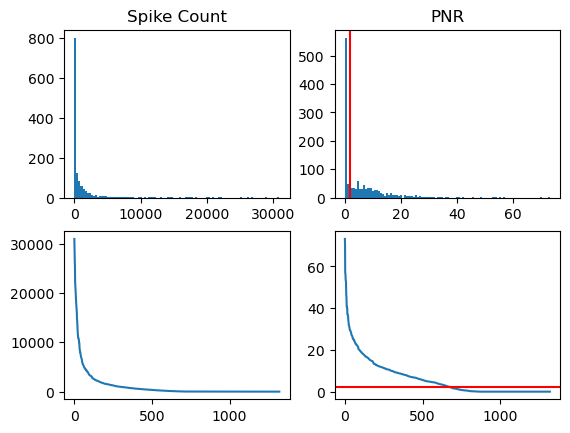

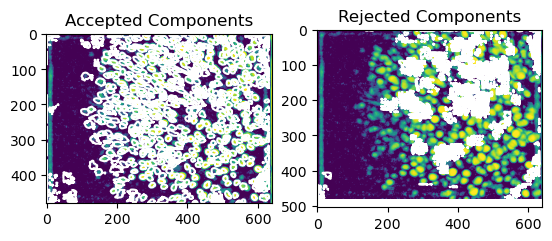

In [7]:
def compute_qc_metrics(A, coordinates, cnm=None, thr = 0.6):
    import numpy.linalg as la
    A = A.toarray()**2
    areas = []
    for i in A.T:
        areas.append((i>np.percentile(i[i>0],thr*10)).sum())
    areas = np.array(areas)
    circums = []
    for coord in coordinates:     
        c = coord['coordinates']
        c = c[~(np.isnan(c).any(axis=1))]
        circums.append( la.norm(c[1:] - c[:-1], axis =1).sum() )
    
    circums = np.array(circums)
    circ = (4 * np.pi * areas)/(circums**2)
    inv_circ = 1/np.array(circ)
    
    if cnm is not None:
        pnrs = cnm.estimates.C.max(axis=1)/cnm.estimates.YrA.std(axis=1)
        s = cnm.estimates.S.astype(bool).astype(int)
        nspikes = s.sum(axis=1)
    else:
        pnrs = None
        nspikes = None
    return areas, inv_circ, pnrs, nspikes


areas, inv_circ, pnrs, nspikes = compute_qc_metrics(cnm.estimates.A, cnm.estimates.coordinates, cnm = cnm)
spike_min = 1
pnr_min =2

fig, ax = plt.subplots(2,2)
ax[0,0].hist(nspikes, 100)
ax[1,0].plot(np.sort(nspikes)[::-1])

ax[0,1].hist(pnrs, 100)
ax[0,1].axvline(pnr_min, color = 'r')
ax[1,1].plot(np.sort(pnrs)[::-1])
ax[1,1].axhline(pnr_min, color = 'r')

ax[0,0].set_title('Spike Count')
ax[0,1].set_title('PNR');
mask = (pnrs>pnr_min) & (nspikes>spike_min)
cnm.estimates.plot_contours(img = cn, idx = np.where(mask)[0], display_numbers = False);

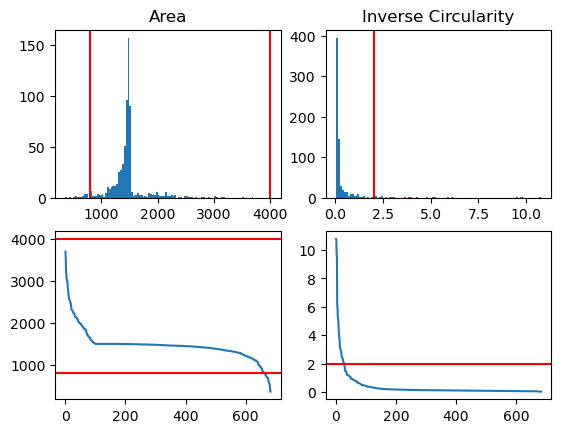

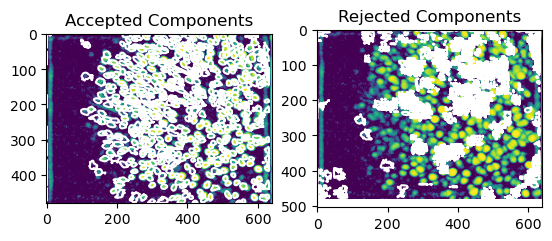

In [8]:
amin = 800
amax = 4000
cmax = 2


fig, ax = plt.subplots(2,2)

ax[0,0].hist(areas[mask], 100)
ax[0,0].axvline(amin, color = 'r')
ax[0,0].axvline(amax, color = 'r')
ax[1,0].plot(np.sort(areas[mask])[::-1])
ax[1,0].axhline(amin, color = 'r')
ax[1,0].axhline(amax, color = 'r')

ax[0,1].hist(inv_circ[mask], 100)
ax[0,1].axvline(cmax, color = 'r')
ax[1,1].plot(np.sort(inv_circ[mask])[::-1])
ax[1,1].axhline(cmax, color = 'r')
ax[0,0].set_title('Area')
ax[0,1].set_title('Inverse Circularity');
mask2 = mask & (areas>amin) & (areas<amax) & (inv_circ<cmax)
cnm.estimates.plot_contours(img = cn, idx = np.where(mask2)[0], display_numbers = False);

In [10]:
cnm.estimates.select_components(np.where(mask2)[0], save_discarded_components = False)


*** Variable g has not the same number of components as A ***
*** Variable c1 has not the same number of components as A ***
*** Variable neurons_sn has not the same number of components as A ***
*** Variable lam has not the same number of components as A ***


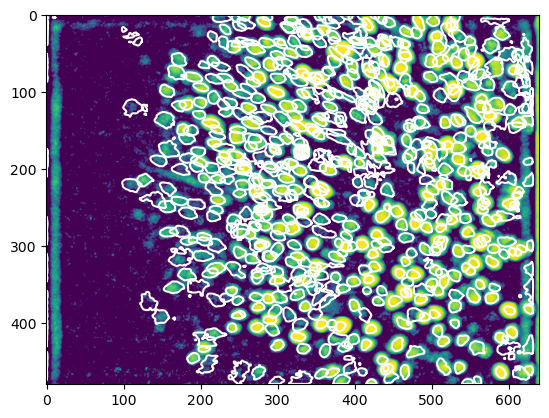

In [11]:
cnm.estimates.plot_contours(img =  cn , display_numbers = False)

In [12]:
aa = cnm.estimates.A.toarray()
#normalize and threshold A
aa = aa/aa.max(axis=0)
aa = (aa>0.6).astype(float)
aa[aa==0] = np.nan

#get centroid locations
x,y = np.meshgrid(np.arange(cnm.estimates.dims[1]), np.arange(cnm.estimates.dims[0]))
xx = np.tile(x.reshape((-1,1), order = 'F'), (1,cnm.estimates.A.shape[1]))
yy = np.tile(y.reshape((-1,1), order = 'F'), (1,cnm.estimates.A.shape[1]))
xc = np.nanmean(aa*xx, axis=0)[:,None]
yc = np.nanmean(aa*yy, axis=0)[:,None]
locs = np.concatenate((xc, yc), axis=1)

# compute the distance matrix
import numpy.linalg as la
dist = la.norm(locs[:,:,None] - locs.T[None,:,:], axis = 1)
corr = np.corrcoef(cnm.estimates.C)
corr[np.arange(corr.shape[0]), np.arange(corr.shape[1])] = np.nan

# pairwise multiply by temporal correlation matrix
dc = (1- dist/np.max(dist)) * corr


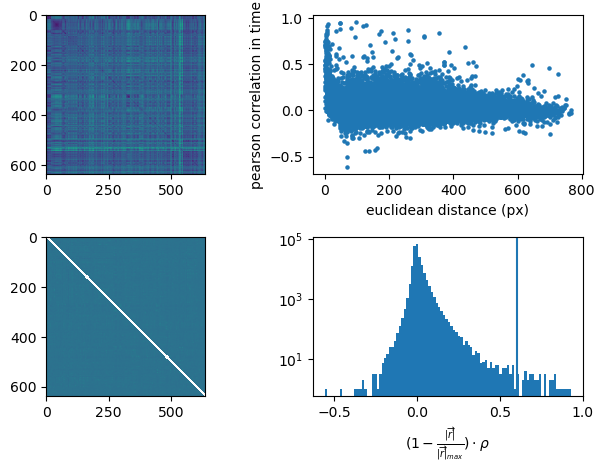

In [13]:
dcmax=.6
i,j = np.tril_indices(dist.shape[0])
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(dist)
ax[0,1].scatter(dist[i,j],corr[i,j], s  =5)
ax[0,1].set_xlabel('euclidean distance (px)')
ax[0,1].set_ylabel('pearson correlation in time')
ax[1,0].imshow(dc);
ax[1,1].hist(dc[i,j], 100, log = True);
ax[1,1].axvline(dcmax)
ax[1,1].set_xlabel(r'$(1-\frac{|\overrightarrow{r}|}{|\overrightarrow{r}|_{max}}) \cdot \rho$ ')
fig.tight_layout(pad = 1.)


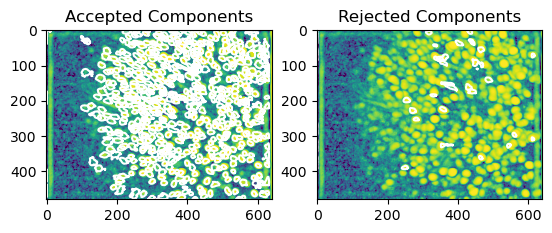

In [14]:
mask3 = ~((np.tril(dc)>dcmax).any(axis=1))
print(mask3.sum())
cnm.estimates.plot_contours(img =  cn , idx = np.where(mask3)[0], display_numbers = False)


In [15]:
cnm.estimates.select_components(np.where(mask3)[0], save_discarded_components = False)

*** Variable g has not the same number of components as A ***
*** Variable c1 has not the same number of components as A ***
*** Variable neurons_sn has not the same number of components as A ***
*** Variable lam has not the same number of components as A ***


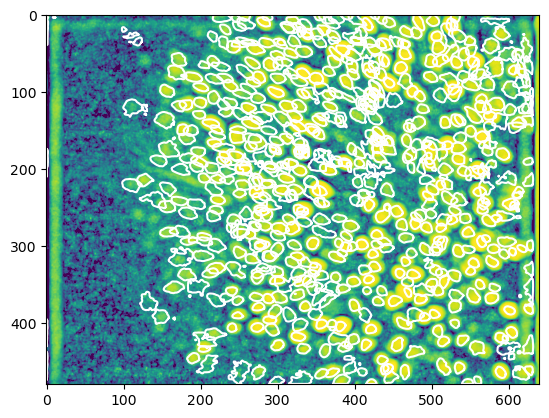

In [23]:
cnm.estimates.plot_contours(img =  cn , display_numbers = False)
plt.savefig(Path(orig).parent/'final_contours.png')

In [ ]:
cnm.save((Path(orig).parent/'cnmf_filtered.hdf5').as_posix())

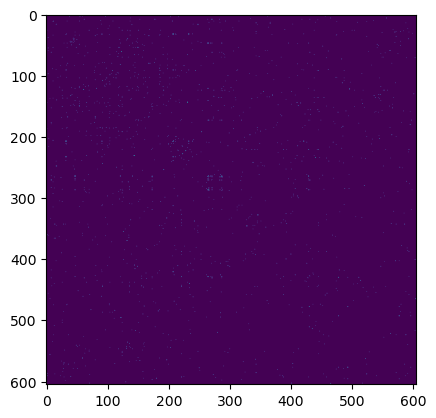

In [17]:
# compute an adjacency matrix from the data for further analysis
import pandas as pd
s = pd.DataFrame(cnm.estimates.S.T)
pcorr = s.corr(method = lambda x, y: st.pearsonr(x, y)[1])
corr = s.corr(method = lambda x, y: st.pearsonr(x, y)[0])
corr[pcorr>.05] = 0
corr[corr<.1]=0
np.save(Path(orig).parent/'adjacency.npy',corr)
plt.imshow(corr)


### taking a look at bleaching in the data

In [21]:
binsize = 10000
nskip = 5
if not (Path(orig).parent/f'local_correlations_binned_{binsize}_skip_{nskip}.npy').exists():
    Yr, dims, T = cm.load_memmap(fname_new)
    images = np.reshape(Yr.T, [T] + list(dims), order='F')
    cns = []
    pnrs = []
    for i in tqdm(range(int(np.ceil(T/binsize)))):
        _cn, _pnr = cm.summary_images.correlation_pnr(images[int(i*binsize):int((i+1)*binsize):nskip], 
                                                      gSig= opts.get('init', 'gSig')[0] * opts.get('online', 'ds_factor'),
                                                      swap_dim=False) 
        cns.append(_cn)
        pnrs.append(_pnr)

    cns = np.array(cns)
    pnrs = np.array(pnrs)

    np.save(Path(orig).parent/f'local_correlations_binned_{binsize}_skip_{nskip}.npy',cns)
    np.save(Path(orig).parent/f'pnr_binned_{binsize}_skip_{nskip}.npy',pnrs)
else:
    cns = np.load(Path(orig).parent/f'local_correlations_binned_{binsize}_skip_{nskip}.npy')
    pnrs = np.load(Path(orig).parent/f'pnr_binned_{binsize}_skip_{nskip}.npy')

100%|██████████| 5/5 [03:34<00:00, 42.96s/it]


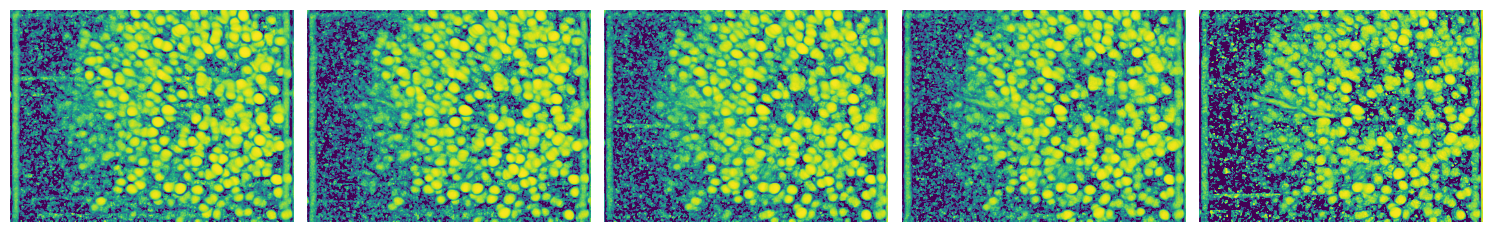

In [33]:
fig, ax = plt.subplots(1,5, figsize = (15,5))
for i in range(cns.shape[0]):
    ax.flatten()[i].imshow(cns[i], vmax = 1, vmin = .7)
    ax.flatten()[i].axis('off')
fig.tight_layout(pad=1.)

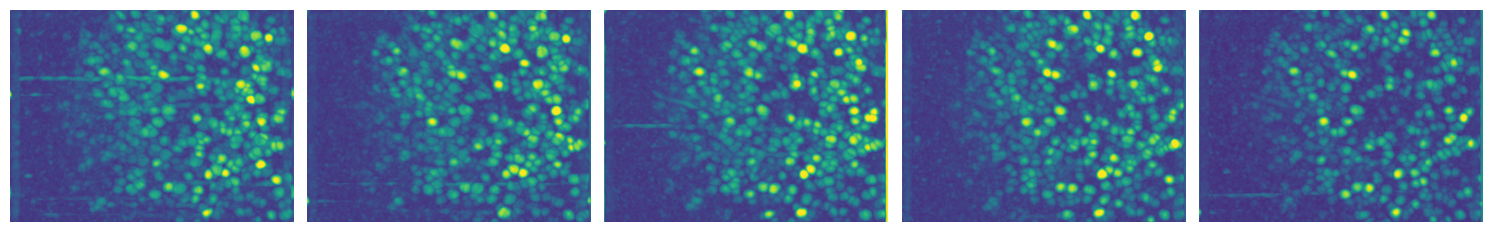

In [27]:
fig, ax = plt.subplots(1,5, figsize = (15,5))
for i in range(cns.shape[0]):
    ax.flatten()[i].imshow(pnrs[i], vmin = 0, vmax=20)
    ax.flatten()[i].axis('off')
fig.tight_layout(pad=1.)


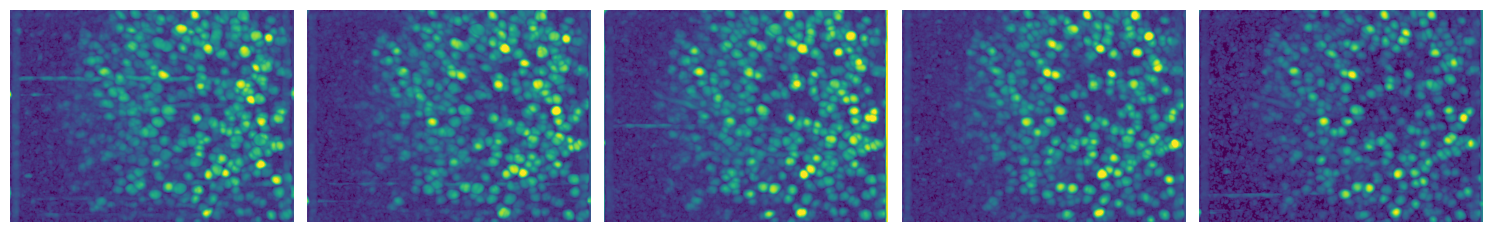

In [28]:
fig, ax = plt.subplots(1,5, figsize = (15,5))
for i in range(cns.shape[0]):
    ax.flatten()[i].imshow(cns[i]*pnrs[i], vmin = 0, vmax=20)
    ax.flatten()[i].axis('off')
fig.tight_layout(pad=1.)


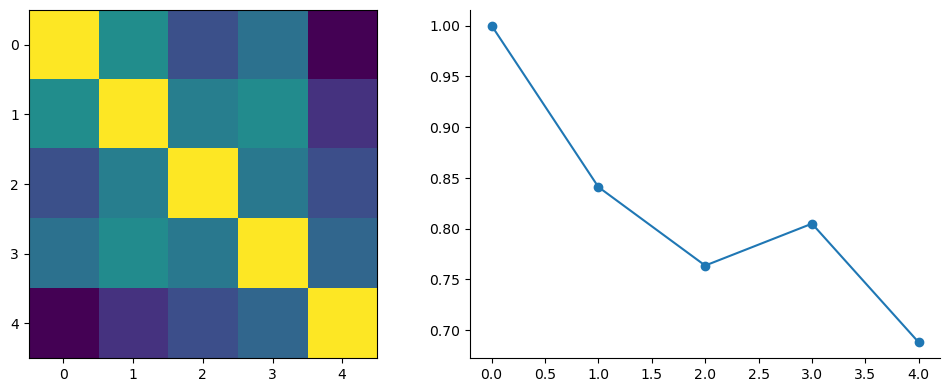

In [30]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
cn_corr=np.corrcoef((cns*pnrs).reshape(cns.shape[0],-1, order = 'C'))
ax[0].imshow(cn_corr)
ax[1].plot(cn_corr[0], marker = 'o')
sns.despine(ax=ax[1])
fig.tight_layout(pad = 1.)
